# Gender classification by first name.

**Goal:** classify a person's first name as male or female.

**Info about the dataset:** 5000 names of Indian origin. 2662 are male, 2365 are female.

**Approach:** 

- Apply Naive Bayes classifier in the last letter, last two letters, and the first letter of the names.

- Use term-frequency times inverse document-frequency (tfidf) vectorization with 2-gram and 3-gram sequences to cerate features for SVM classifier and Multilayer Perceptron classifier.

- Use simple integer encoding and apply a recurrent neural network with one and multiple Long short-term memory (LSTM) layers.

**Results:**

| **Model** | accuracy | 
|--------------------|----------|
|NB last letter      |   0.80   |
|NB last two letters |   0.82   |
|NB first letter     |   0.56   |
|SVM tfidf vect.     |   0.73   |
|MLP first letter    |   0.69   |
|RNN with LSTM       |   0.84   |

**Conclusions:**

The top performer was a recurrent neural network with one LSTM bi-directional layer. It is worth noting that a simple approach using Naive Bayes classifier on the last two letters was the second best.


In [0]:
%tensorflow_version 2.x
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from sklearn.svm import SVC
%matplotlib inline

In [2]:
print(tf.__version__)

2.1.0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Load dataset
names = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/capstone2/gender_classification/names.csv')
names['Name'] = names['Name'].str.strip()
names['Name'] = names['Name'].str.lower()
names['FirstLetter'] = names['FirstLetter'].str.lower()

In [5]:
names.head(5)

,Name,Gender,LastLetter,LastTwoLetter,FirstLetter
0,ashutosh,1,h,sh,a
1,meghamala,2,a,la,m
2,sahib,1,b,ib,s
3,pragya,2,a,ya,p
4,kranti,2,i,ti,k


In [6]:
# Count the number of entries corresponding to male (1) and female (2) names.
names.Gender.value_counts()

1    2662
2    2365
Name: Gender, dtype: int64

# Naive Bayes on the last letter

In [0]:
# Get last letters and labels
last_letter = names.LastLetter.values
labels = names.Gender.values

In [0]:
def naive_bayes_classifier(features, labels):
    '''This function splits the datset into train and test sets,
    performs one-hot encoding of the characters,
    and fits Naive Bayes classifier, the accuracies of 
    testing and training as well as classification report
    are printed out. '''
    
    # Split the data into a training and test set.
    X_train, X_test, y_train, y_test = train_test_split(features.reshape(-1, 1), 
                                                        labels.reshape(-1, 1).ravel(), 
                                                        test_size = 0.3,
                                                        stratify = labels)

    encoder = OneHotEncoder(handle_unknown='ignore')
    X_train = encoder.fit_transform(X_train)
    X_test = encoder.transform(X_test)

    nb_clf = MultinomialNB()

    # Fit the model on the trainng data.
    nb_clf.fit(X_train, y_train)

    # Print the accuracy from the training data.
    print('The mean accuracy on the given train data and labels = ' + 
          str(nb_clf.score(X_train, y_train)))

    # Print the accuracy from the testing data.
    print('The mean accuracy on the given test data and labels = ' + 
          str(nb_clf.score(X_test, y_test)))
    
    # Print classification report based on test data
    print(classification_report(y_true=y_test, 
                                y_pred=nb_clf.predict(X_test)))


In [9]:
naive_bayes_classifier(last_letter, labels)

The mean accuracy on the given train data and labels = 0.8308698123934053
The mean accuracy on the given test data and labels = 0.7978793903247183
              precision    recall  f1-score   support

           1       0.87      0.73      0.79       799
           2       0.74      0.88      0.80       710

    accuracy                           0.80      1509
   macro avg       0.81      0.80      0.80      1509
weighted avg       0.81      0.80      0.80      1509



# Naive Bayes on the last two letters

In [0]:
# Get last two letters
last_two_letters = names.LastTwoLetter.values

In [11]:
naive_bayes_classifier(last_two_letters, labels)

The mean accuracy on the given train data and labels = 0.8362706083001705
The mean accuracy on the given test data and labels = 0.8223989396951623
              precision    recall  f1-score   support

           1       0.85      0.81      0.83       799
           2       0.80      0.84      0.82       710

    accuracy                           0.82      1509
   macro avg       0.82      0.82      0.82      1509
weighted avg       0.82      0.82      0.82      1509



# Naive Bayes on the first letter

In [0]:
# Get first letter from each name
first_letter = names.FirstLetter.values

In [13]:
naive_bayes_classifier(first_letter, labels)

The mean accuracy on the given train data and labels = 0.5511654349061967
The mean accuracy on the given test data and labels = 0.5559973492379059
              precision    recall  f1-score   support

           1       0.57      0.65      0.61       799
           2       0.53      0.45      0.49       710

    accuracy                           0.56      1509
   macro avg       0.55      0.55      0.55      1509
weighted avg       0.55      0.56      0.55      1509



# SVM on tfidf vectorized dataset

In [0]:
def svm_classifier(df):
    '''This function splits the datset into train and test sets,
    performs encoding of the characters using TfidfVectorizer,
    and fits SVM classifier, the accuracies of 
    testing and training as well as classification report
    are printed out. '''

    labels = (df.Gender == 1).values.astype(np.int)
    features = df.Name

    # Split the data into a training and test set.
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                        labels.reshape(-1, 1).ravel(), 
                                                        test_size = 0.3,
                                                        stratify = labels)

    vectorizer = TfidfVectorizer(min_df=0.0, analyzer='char', 
                                 ngram_range=(2, 3), 
                                 decode_error='ignore')
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Define a default SVM classifier
    svm_clf = SVC()

    # Fit the model on the training data.
    svm_clf.fit(X_train, y_train)

    # Print the accuracy from the training data.
    print('The mean accuracy on the given train data and labels = ' + 
          str(svm_clf.score(X_train, y_train)))

    # Print the accuracy from the testing data.
    print('The mean accuracy on the given test data and labels = ' + 
          str(svm_clf.score(X_test, y_test)))
    
    # Print classification report based on test data
    print(classification_report(y_true=y_test, 
                                y_pred=svm_clf.predict(X_test)))

In [15]:
svm_classifier(names)

The mean accuracy on the given train data and labels = 0.9440022740193291
The mean accuracy on the given test data and labels = 0.7309476474486415
              precision    recall  f1-score   support

           0       0.72      0.69      0.71       710
           1       0.74      0.77      0.75       799

    accuracy                           0.73      1509
   macro avg       0.73      0.73      0.73      1509
weighted avg       0.73      0.73      0.73      1509



# Train-test split, TfidfVectorized dataset (for multi-layer perceptron network)




In [0]:
def make_tfidf_train_test(df):   
    '''This function splits dataset into train and test sets, 
    TfidfVectorizer is fitted on train and applied on test set,
    then train, valid and test tensors are created, they are 
    returned together with the input shape.''' 

    labels = (df.Gender == 1).values.astype(np.int)
    features = df.Name

    # Using train_test_split() to get train and test datasets from intitial dataset
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                        labels.reshape(-1, 1).ravel(), 
                                                        test_size = 0.3,
                                                        stratify = labels)

    vectorizer = TfidfVectorizer(min_df=0.0, 
                                 analyzer='char', 
                                 ngram_range=(2, 3), 
                                 decode_error='ignore')
  
    X_train = vectorizer.fit_transform(X_train).toarray()
    X_test = vectorizer.transform(X_test).toarray()

    ds_train_valid = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_train = ds_train_valid.take(int(0.7 * np.shape(X_train)[0]))
    ds_valid = ds_train_valid.skip(int(0.7 * np.shape(X_train)[0]))
    ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    input_shape = np.shape(X_train)[1]
    ds_train_len = len(X_train)

    return ds_train, ds_valid, ds_test, input_shape    

In [0]:
tfidf_train_orig, tfidf_valid_orig, tfidf_test, tfidf_input_shape = make_tfidf_train_test(names)

# Train-test split, integer encoded dataset (for recursive neural network).

In [0]:
def get_integer(x):
    '''This function maps unique integers to
    ascii characters.'''

    chars = list(string.ascii_lowercase)
    ints = list(range(1,27))
    chars_ints_dict = dict(zip(chars, ints)) 

    return chars_ints_dict.get(x)   

In [0]:
def char2sequence_mapping(data):
    '''This function returns features for a recurrent network,
    which is 2D numpy array containing integer encoded 
    first names.'''

    # Remap names to lists of integers
    data['name_sequence'] = data['Name'].apply(lambda name: list( map(get_integer,name)))
    
    # Fill unused spaces in name vectors with zeros.
    rnn_data_features = np.array(pd.DataFrame(data.name_sequence.tolist()).fillna(0))
    
    # Truncate length of names to length of 26
    rnn_data_features = rnn_data_features[:,:26]

    return rnn_data_features

In [0]:
rnn_features = char2sequence_mapping(names)

In [0]:
def make_rnn_train_test(df, features):   
    '''This function splits dataset into train and test sets, 
    then train, valid and test tensors are created, they are 
    returned together with the input shape.''' 

    labels = (df.Gender == 1).values.astype(np.int)

    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                        labels.reshape(-1, 1).ravel(), 
                                                        test_size = 0.3,
                                                        stratify = labels)

    ds_train_valid = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_train = ds_train_valid.take(int(0.7 * np.shape(X_train)[0]))
    ds_valid = ds_train_valid.skip(int(0.7 * np.shape(X_train)[0]))
    ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    input_shape = np.shape(X_train)[1]
    ds_train_len = len(X_train)

    return ds_train, ds_valid, ds_test, input_shape

In [0]:
rnn_train_orig, rnn_valid_orig, rnn_test, rnn_input_shape = make_rnn_train_test(names,rnn_features)

**Calculate number of entries in training, validation and test sets.**

In [44]:
train_size = 0
for example in rnn_train_orig:
    train_size += 1
print('Number of training entries: ', train_size)

valid_size = 0
for example in rnn_valid_orig:
    valid_size += 1
print('Number of validation entries: ',valid_size)

test_size = 0
for example in rnn_test:
    test_size += 1
print('Number of test entries: ',test_size)

Number of training entries:  2462
Number of validation entries:  1056
Number of test entries:  1509


# Function for fitting neural network model and plotting model's train-validation curves.

In [0]:
def fitting_neural_network(model, batch, epochs, ds_train_orig, ds_valid_orig):
    ''' This function shuffles the train and test sets,
    takes a batch from each, then uses them to fit a 
    tensorflow model.'''

    num_epochs = epochs
    batch_size = batch
    steps_train = np.ceil(train_size / batch_size)
    steps_valid = np.ceil(valid_size / batch_size)

    ds_train = ds_train_orig.shuffle(buffer_size=train_size)
    ds_train = ds_train.repeat()
    ds_train = ds_train.batch(batch_size=batch_size)
    ds_train = ds_train.prefetch(buffer_size=1000)

    ds_valid = ds_valid_orig.shuffle(buffer_size=valid_size)
    ds_valid = ds_valid.repeat()
    ds_valid = ds_valid.batch(batch_size=batch_size)
    ds_valid = ds_valid.prefetch(buffer_size=1000)

    history = model.fit(ds_train, 
                        epochs=num_epochs, 
                        steps_per_epoch=steps_train, 
                        validation_data = ds_valid, 
                        validation_steps = steps_valid)
    return history

In [0]:
def plot_train_valid(model_history):
    '''This function plots training - validation history
    of a tensorflow model.'''

    hist = model_history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)

    return plt.show()

# Multilayer perceptron

In [66]:
tf.keras.backend.clear_session()
mlp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(150, 
                          activation='relu', 
                          name='fully_connected1', 
                          input_shape=(tfidf_input_shape,)),
    tf.keras.layers.Dropout(rate = 0.9,
                            name='dropout1'),
    tf.keras.layers.Dense(100, 
                          activation='relu', 
                          name='fully_connected2'),
    tf.keras.layers.Dropout(rate = 0.75,
                            name='dropout2'),
    tf.keras.layers.Dense(50, 
                          activation='relu', 
                          name='fully_connected3'),
    tf.keras.layers.Dropout(rate = 0.5,
                            name='dropout3'),
    tf.keras.layers.Dense(2, 
                          name='output', 
                          activation='sigmoid')])

mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fully_connected1 (Dense)     (None, 150)               406650    
_________________________________________________________________
dropout1 (Dropout)           (None, 150)               0         
_________________________________________________________________
fully_connected2 (Dense)     (None, 100)               15100     
_________________________________________________________________
dropout2 (Dropout)           (None, 100)               0         
_________________________________________________________________
fully_connected3 (Dense)     (None, 50)                5050      
_________________________________________________________________
dropout3 (Dropout)           (None, 50)                0         
_________________________________________________________________
output (Dense)               (None, 2)                 1

In [0]:
mlp_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [68]:
mlp_hist = fitting_neural_network(mlp_model, 
                                  batch = 4, 
                                  epochs = 10, 
                                  ds_train_orig=tfidf_train_orig, 
                                  ds_valid_orig=tfidf_valid_orig)

Train for 616.0 steps, validate for 264.0 steps
Epoch 1/10
616/616 [==============================] - 3s 5ms/step - loss: 0.6946 - accuracy: 0.5041 - val_loss: 0.6885 - val_accuracy: 0.5473
Epoch 2/10
616/616 [==============================] - 3s 4ms/step - loss: 0.6914 - accuracy: 0.5377 - val_loss: 0.6878 - val_accuracy: 0.5871
Epoch 3/10
616/616 [==============================] - 3s 4ms/step - loss: 0.6862 - accuracy: 0.5292 - val_loss: 0.6739 - val_accuracy: 0.6146
Epoch 4/10
616/616 [==============================] - 3s 5ms/step - loss: 0.6763 - accuracy: 0.5731 - val_loss: 0.6652 - val_accuracy: 0.6477
Epoch 5/10
616/616 [==============================] - 3s 5ms/step - loss: 0.6620 - accuracy: 0.6027 - val_loss: 0.6559 - val_accuracy: 0.6420
Epoch 6/10
616/616 [==============================] - 2s 4ms/step - loss: 0.6522 - accuracy: 0.6230 - val_loss: 0.6404 - val_accuracy: 0.6487
Epoch 7/10
616/616 [==============================] - 2s 4ms/step - loss: 0.6316 - accuracy: 0.6408 

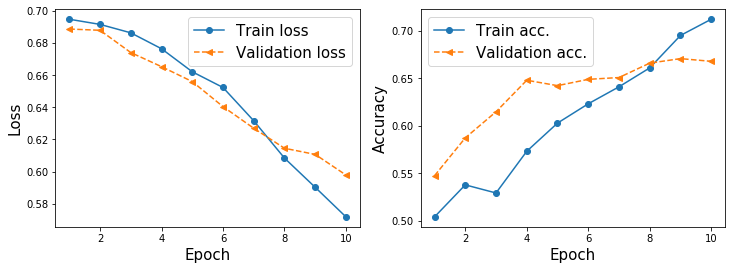

In [69]:
plot_train_valid(mlp_hist)

In [70]:
mlp_results = mlp_model.evaluate(tfidf_test.batch(test_size))
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*mlp_results))

1/1 [==============================] - 0s 41ms/step - loss: 0.5899 - accuracy: 0.6912
Test loss: 0.5899   Test Acc.: 0.6912


# Bidirectional RNN with LSTM layer.

In [89]:
tf.keras.backend.clear_session()

embedding_dim = 26
vocab_size = rnn_input_shape + 2

bi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim,
                              name='embed-layer'),
    
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(150)), 
    
    tf.keras.layers.Dense(2, 
                          activation = 'softmax',
                          name = 'output')
])

bi_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 26)          728       
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               212400    
_________________________________________________________________
output (Dense)               (None, 2)                 602       
Total params: 213,730
Trainable params: 213,730
Non-trainable params: 0
_________________________________________________________________


In [0]:
bi_lstm_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [91]:
bi_lstm_hist = fitting_neural_network(bi_lstm_model, 
                                      batch=8, 
                                      epochs=10, 
                                      ds_train_orig=rnn_train_orig, 
                                      ds_valid_orig=rnn_valid_orig)

Train for 308.0 steps, validate for 132.0 steps
Epoch 1/10
308/308 [==============================] - 6s 18ms/step - loss: 0.6727 - accuracy: 0.5925 - val_loss: 0.6348 - val_accuracy: 0.6562
Epoch 2/10
308/308 [==============================] - 3s 9ms/step - loss: 0.5487 - accuracy: 0.7350 - val_loss: 0.5288 - val_accuracy: 0.7462
Epoch 3/10
308/308 [==============================] - 3s 10ms/step - loss: 0.4916 - accuracy: 0.7950 - val_loss: 0.4745 - val_accuracy: 0.8097
Epoch 4/10
308/308 [==============================] - 3s 9ms/step - loss: 0.4321 - accuracy: 0.8271 - val_loss: 0.4334 - val_accuracy: 0.8144
Epoch 5/10
308/308 [==============================] - 3s 8ms/step - loss: 0.3943 - accuracy: 0.8393 - val_loss: 0.4091 - val_accuracy: 0.8277
Epoch 6/10
308/308 [==============================] - 3s 9ms/step - loss: 0.3836 - accuracy: 0.8454 - val_loss: 0.4346 - val_accuracy: 0.8182
Epoch 7/10
308/308 [==============================] - 3s 9ms/step - loss: 0.3813 - accuracy: 0.842

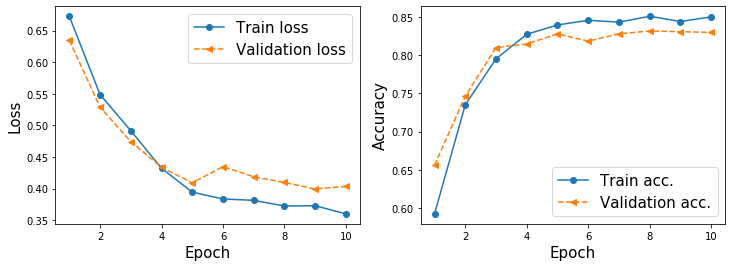

In [92]:
plot_train_valid(bi_lstm_hist)

In [93]:
# evaluate bi_lstm_model on the test data
bi_lstm_results = bi_lstm_model.evaluate(rnn_test.batch(test_size))
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*bi_lstm_results))

1/1 [==============================] - 0s 14ms/step - loss: 0.3924 - accuracy: 0.8449
Test loss: 0.3924   Test Acc.: 0.8449


# Bidirectional LSTM with multiple dropout layers.

In [84]:
tf.keras.backend.clear_session()

embedding_dim = 26
vocab_size = rnn_input_shape + 2

model_multiple_lstms = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim),
    tf.keras.layers.Dense(100,
                          input_shape=(embedding_dim,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(100, 
                             return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(100,
                             return_sequences=False)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2, 
                          activation='softmax')
])

print(model_multiple_lstms.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 26)          728       
_________________________________________________________________
dense (Dense)                (None, None, 100)         2700      
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 200)         160800    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0

In [0]:
model_multiple_lstms.compile(loss='sparse_categorical_crossentropy',
                             optimizer='adam',
                             metrics=['accuracy'])

In [86]:
model_multiple_lstms_hist = fitting_neural_network(model_multiple_lstms, 
                                                   batch=8, 
                                                   epochs=10, 
                                                   ds_train_orig=rnn_train_orig, 
                                                   ds_valid_orig=rnn_valid_orig)

Train for 308.0 steps, validate for 132.0 steps
Epoch 1/10
308/308 [==============================] - 9s 29ms/step - loss: 0.6326 - accuracy: 0.6315 - val_loss: 0.5248 - val_accuracy: 0.7699
Epoch 2/10
308/308 [==============================] - 5s 15ms/step - loss: 0.4614 - accuracy: 0.7975 - val_loss: 0.4177 - val_accuracy: 0.8182
Epoch 3/10
308/308 [==============================] - 5s 15ms/step - loss: 0.4151 - accuracy: 0.8235 - val_loss: 0.4308 - val_accuracy: 0.8153
Epoch 4/10
308/308 [==============================] - 5s 15ms/step - loss: 0.4051 - accuracy: 0.8373 - val_loss: 0.4003 - val_accuracy: 0.8333
Epoch 5/10
308/308 [==============================] - 4s 15ms/step - loss: 0.3925 - accuracy: 0.8429 - val_loss: 0.4133 - val_accuracy: 0.8277
Epoch 6/10
308/308 [==============================] - 5s 15ms/step - loss: 0.3780 - accuracy: 0.8498 - val_loss: 0.4193 - val_accuracy: 0.8258
Epoch 7/10
308/308 [==============================] - 4s 14ms/step - loss: 0.3735 - accuracy: 

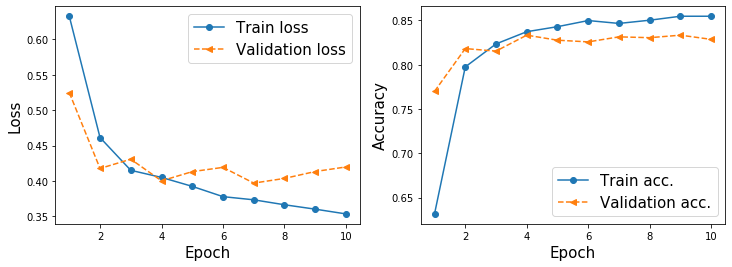

In [87]:
plot_train_valid(model_multiple_lstms_hist)

In [88]:
# evaluate model on the test data
model_multiple_lstms_results = model_multiple_lstms.evaluate(rnn_test.batch(test_size))
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*model_multiple_lstms_results))

1/1 [==============================] - 0s 22ms/step - loss: 0.4083 - accuracy: 0.8290
Test loss: 0.4083   Test Acc.: 0.8290
